In [1]:
#!/usr/bin/env python
# coding: utf-8

# 1. Setting Up

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import models, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define paths
DATA_PATH = "../data/processed/images"


In [3]:
# Set device to CPI
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. DataSet

In [4]:
class FitzpatrickDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_condition=None):
        """
        Args:
            csv_file: Path to the CSV file with annotations
            root_dir: Directory with all the images
            transform: Optional transform to be applied on a sample
            target_condition: If specified, only include this skin condition or list of conditions
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        # Verify image paths exist
        self.data_frame['image_exists'] = self.data_frame['image_path'].apply(os.path.exists)
        self.data_frame = self.data_frame[self.data_frame['image_exists']]
        self.data_frame = self.data_frame.drop('image_exists', axis=1)
        
        # Filter by condition if specified
        if target_condition is not None:
            if isinstance(target_condition, list):
                # Filter for multiple conditions
                self.data_frame = self.data_frame[self.data_frame['label'].isin(target_condition)]
            else:
                # Filter for a single condition
                self.data_frame = self.data_frame[self.data_frame['label'] == target_condition]
        
        # Convert three_partition_label to binary (malignant vs. non-malignant)
        self.data_frame['binary_label'] = self.data_frame['three_partition_label'].apply(
            lambda x: 1 if x == 'malignant' else 0
        )
        
        # Group skin types into light (1-3) and dark (4-6)
        self.data_frame['skin_group'] = self.data_frame['fitzpatrick_scale'].apply(
            lambda x: 0 if x <= 3 else 1  # 0 for light, 1 for dark
        )
        
        # Create a mapping for unique conditions
        self.unique_conditions = self.data_frame['label'].unique()
        self.condition_to_idx = {condition: idx for idx, condition in enumerate(self.unique_conditions)}
        
        # Add multi-class label
        self.data_frame['condition_idx'] = self.data_frame['label'].apply(lambda x: self.condition_to_idx[x])
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_path = self.data_frame.iloc[idx]['image_path']
        
        try:
            # Use PIL to load image
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a placeholder image if loading fails
            image = Image.new('RGB', (224, 224), color='gray')
        
        # Get labels
        binary_label = float(self.data_frame.iloc[idx]['binary_label'])  # Convert to float
        skin_type = int(self.data_frame.iloc[idx]['fitzpatrick_scale'])
        skin_group = int(self.data_frame.iloc[idx]['skin_group'])
        condition_idx = int(self.data_frame.iloc[idx]['condition_idx'])
        
        if self.transform:
            image = self.transform(image)
        
        # Return all necessary information
        return image, binary_label, skin_type, skin_group, condition_idx



# 3. Load Data

In [5]:
def load_data(batch_size=32, target_condition=None, max_samples=None):
    """
    Load and prepare the datasets with optimization for speed
    """
    # Define transforms with smaller image size
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Smaller size for faster training
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    # Create datasets
    train_dataset = FitzpatrickDataset(
        csv_file=os.path.join(DATA_PATH, 'train_split.csv'),
        root_dir=DATA_PATH,
        transform=transform,
        target_condition=target_condition
    )
    
    val_dataset = FitzpatrickDataset(
        csv_file=os.path.join(DATA_PATH, 'val_split.csv'),
        root_dir=DATA_PATH,
        transform=transform,
        target_condition=target_condition
    )
    
    test_dataset = FitzpatrickDataset(
        csv_file=os.path.join(DATA_PATH, 'test_split.csv'),
        root_dir=DATA_PATH,
        transform=transform,
        target_condition=target_condition
    )
    
    # Optionally limit the number of samples
    if max_samples is not None:
        # Simple random sampling for testing
        if len(train_dataset) > max_samples:
            indices = torch.randperm(len(train_dataset))[:max_samples]
            train_dataset = torch.utils.data.Subset(train_dataset, indices)
        if len(val_dataset) > max_samples // 5:
            indices = torch.randperm(len(val_dataset))[:max_samples // 5]
            val_dataset = torch.utils.data.Subset(val_dataset, indices)
        if len(test_dataset) > max_samples // 5:
            indices = torch.randperm(len(test_dataset))[:max_samples // 5]
            test_dataset = torch.utils.data.Subset(test_dataset, indices)
    
    # Create dataloaders with fewer workers and persistent_workers=False
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0,  # Use 0 workers to debug
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,  # Use 0 workers to debug
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,  # Use 0 workers to debug
        pin_memory=True
    )
    
    # Get unique conditions (handle the case when train_dataset is a Subset)
    if isinstance(train_dataset, torch.utils.data.Subset):
        # Get the original dataset
        original_dataset = train_dataset.dataset
        unique_conditions = original_dataset.unique_conditions
    else:
        unique_conditions = train_dataset.unique_conditions
    
    return train_loader, val_loader, test_loader, unique_conditions


In [13]:
# Load a smaller dataset with focus on key conditions
#target_conditions = ['psoriasis', 'squamous_cell_carcinoma', 'lichen_planus']
train_loader, val_loader, test_loader, unique_conditions = load_data(
    batch_size=32,
    target_condition=None,
    max_samples=None  # Limit total samples
)

# 4. Model Architecture

Using ResNet 18 instead of VGG16 as paper for faster training

In [14]:
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(ResNet18Classifier, self).__init__()
        self.model = models.resnet18(pretrained=pretrained)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.model(x)



In [15]:
# Create model function
num_classes = len(unique_conditions)
model = ResNet18Classifier(num_classes=num_classes)
model.to(device)

ResNet18Classifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

# 5. Training Function

Including mixed precision for faster training

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device='cpu'):
    """
    Train the model and validate after each epoch
    """
    model.to(device)
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in train_loader:
            # Handle both Subset and regular dataset formats
            if isinstance(batch, tuple) and len(batch) == 5:
                images, labels, _, _, _ = batch
            else:
                # If using a Subset, the __getitem__ might return a different format
                images = batch[0]
                labels = batch[1]
            
            images = images.to(device)
            labels = labels.to(device).long()  # Ensure labels are long type for CrossEntropyLoss
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for batch in val_loader:
                    # Handle both Subset and regular dataset formats
                    if isinstance(batch, tuple) and len(batch) == 5:
                        images, labels, _, _, _ = batch
                    else:
                        images = batch[0]
                        labels = batch[1]
                    
                    images = images.to(device)
                    labels = labels.to(device).long()
                    
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            val_loss = val_loss / val_total
            val_acc = val_correct / val_total
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), 'fitzpatrick_model_best.pth')
        else:
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
    
    return model, history




In [17]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train model
num_epochs = 10
model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, 
    num_epochs=num_epochs, device=device
)

Epoch 1/10, Train Loss: 1.3995, Train Acc: 0.7471, Val Loss: 0.3808, Val Acc: 0.9005
Epoch 2/10, Train Loss: 0.1353, Train Acc: 0.9662, Val Loss: 0.3273, Val Acc: 0.9005
Epoch 3/10, Train Loss: 0.0511, Train Acc: 0.9879, Val Loss: 0.3211, Val Acc: 0.9039
Epoch 4/10, Train Loss: 0.0274, Train Acc: 0.9960, Val Loss: 0.3326, Val Acc: 0.8971
Epoch 5/10, Train Loss: 0.0153, Train Acc: 0.9978, Val Loss: 0.3453, Val Acc: 0.9074
Epoch 6/10, Train Loss: 0.0155, Train Acc: 0.9967, Val Loss: 0.3589, Val Acc: 0.8971
Epoch 7/10, Train Loss: 0.0096, Train Acc: 0.9985, Val Loss: 0.3755, Val Acc: 0.9022
Epoch 8/10, Train Loss: 0.0066, Train Acc: 0.9989, Val Loss: 0.3991, Val Acc: 0.9039
Epoch 9/10, Train Loss: 0.0332, Train Acc: 0.9908, Val Loss: 0.5088, Val Acc: 0.8937
Epoch 10/10, Train Loss: 0.0510, Train Acc: 0.9835, Val Loss: 0.4222, Val Acc: 0.8937


# 6. MODEL VALIDATION

In [23]:
def evaluate_stratified(model, test_loader):
    """
    Evaluate model performance with stratification by skin type and condition
    """
    model.eval()
    
    # Initialize dictionaries to store results
    results_by_skin_type = {i: {'preds': [], 'labels': []} for i in range(1, 7)}
    results_by_skin_group = {'light': {'preds': [], 'labels': []}, 'dark': {'preds': [], 'labels': []}}
    results_by_condition = {}
    
    all_preds = []
    all_labels = []
    all_skin_types = []
    all_conditions = []
    
    with torch.no_grad():
        for images, binary_labels, skin_types, skin_groups, condition_idxs in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float().cpu().numpy().flatten()
            
            # Store predictions and labels
            all_preds.extend(preds)
            all_labels.extend(binary_labels.numpy())
            all_skin_types.extend(skin_types.numpy())
            all_conditions.extend(condition_idxs.numpy())
            
            # Store by skin type
            for i in range(len(binary_labels)):
                skin_type = int(skin_types[i].item())
                if 1 <= skin_type <= 6:  # Valid skin type
                    results_by_skin_type[skin_type]['preds'].append(preds[i])
                    results_by_skin_type[skin_type]['labels'].append(binary_labels[i].item())
                
                # Store by skin group (light vs dark)
                group = 'light' if skin_groups[i].item() == 0 else 'dark'
                results_by_skin_group[group]['preds'].append(preds[i])
                results_by_skin_group[group]['labels'].append(binary_labels[i].item())
                
                # Store by condition
                condition = int(condition_idxs[i].item())
                if condition not in results_by_condition:
                    results_by_condition[condition] = {'preds': [], 'labels': [], 'skin_types': []}
                results_by_condition[condition]['preds'].append(preds[i])
                results_by_condition[condition]['labels'].append(binary_labels[i].item())
                results_by_condition[condition]['skin_types'].append(skin_type)
    
    # Calculate metrics for overall performance
    overall_metrics = calculate_metrics(np.array(all_labels), np.array(all_preds))
    
    # Calculate metrics by skin type
    skin_type_metrics = {}
    for skin_type, data in results_by_skin_type.items():
        if len(data['labels']) > 0:
            skin_type_metrics[skin_type] = calculate_metrics(
                np.array(data['labels']), np.array(data['preds'])
            )
    
    # Calculate metrics by skin group (light vs dark)
    light_metrics = calculate_metrics(
        np.array(results_by_skin_group['light']['labels']), 
        np.array(results_by_skin_group['light']['preds'])
    )
    dark_metrics = calculate_metrics(
        np.array(results_by_skin_group['dark']['labels']), 
        np.array(results_by_skin_group['dark']['preds'])
    )
    
    # Calculate metrics by condition
    condition_metrics = {}
    for condition, data in results_by_condition.items():
        if len(data['labels']) > 0:
            # Overall metrics for this condition
            condition_metrics[condition] = {
                'overall': calculate_metrics(np.array(data['labels']), np.array(data['preds'])),
                'by_skin_group': {}
            }
            
            # Split by skin group for this condition
            light_indices = [i for i, st in enumerate(data['skin_types']) if st <= 3]
            dark_indices = [i for i, st in enumerate(data['skin_types']) if st >= 4]
            
            if light_indices:
                light_labels = np.array([data['labels'][i] for i in light_indices])
                light_preds = np.array([data['preds'][i] for i in light_indices])
                condition_metrics[condition]['by_skin_group']['light'] = calculate_metrics(light_labels, light_preds)
            
            if dark_indices:
                dark_labels = np.array([data['labels'][i] for i in dark_indices])
                dark_preds = np.array([data['preds'][i] for i in dark_indices])
                condition_metrics[condition]['by_skin_group']['dark'] = calculate_metrics(dark_labels, dark_preds)
    
    return {
        'overall': overall_metrics,
        'by_skin_type': skin_type_metrics,
        'light_skin': light_metrics,
        'dark_skin': dark_metrics,
        'by_condition': condition_metrics
    }

def calculate_metrics(y_true, y_pred):
    """
    Calculate classification metrics
    """
    # Ensure we have enough samples of each class
    if len(np.unique(y_true)) < 2 or len(y_true) < 5:
        return {
            'accuracy': np.mean(y_true == y_pred) if len(y_true) > 0 else 0,
            'insufficient_data': True
        }
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1': f1,
        'confusion_matrix': np.array([[tn, fp], [fn, tp]])
    }

def visualize_stratified_results(results):
    """
    Visualize the stratified evaluation results
    """
    # Plot accuracy by skin type
    plt.figure(figsize=(12, 6))
    
    # Extract skin type metrics
    skin_types = sorted(results['by_skin_type'].keys())
    accuracies = [results['by_skin_type'][st]['accuracy'] for st in skin_types]
    sensitivities = [results['by_skin_type'][st]['sensitivity'] for st in skin_types]
    
    # Plot
    plt.subplot(1, 2, 1)
    plt.bar(skin_types, accuracies, color='skyblue')
    plt.xlabel('Fitzpatrick Skin Type')
    plt.ylabel('Accuracy')
    plt.title('Accuracy by Skin Type')
    plt.ylim(0, 1)
    
    plt.subplot(1, 2, 2)
    plt.bar(skin_types, sensitivities, color='salmon')
    plt.xlabel('Fitzpatrick Skin Type')
    plt.ylabel('Sensitivity')
    plt.title('Sensitivity by Skin Type')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Compare light vs dark skin performance
    metrics = ['accuracy', 'sensitivity', 'specificity', 'precision', 'f1']
    light_values = [results['light_skin'][m] for m in metrics]
    dark_values = [results['dark_skin'][m] for m in metrics]
    
    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, light_values, width, label='Light Skin (1-3)')
    plt.bar(x + width/2, dark_values, width, label='Dark Skin (4-6)')
    
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Performance Comparison: Light vs Dark Skin')
    plt.xticks(x, metrics)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot condition-specific results
    # This would be more complex and depend on your specific conditions
    # Here's a simplified version for the top 3 conditions
    
    # Get top 3 conditions by sample count
    condition_counts = {c: len(results['by_condition'][c]['overall']['confusion_matrix'].flatten()) 
                       for c in results['by_condition']}
    top_conditions = sorted(condition_counts.keys(), key=lambda x: condition_counts[x], reverse=True)[:3]
    
    # Plot accuracy for top conditions by skin group
    plt.figure(figsize=(12, 6))
    
    for i, condition in enumerate(top_conditions):
        cond_data = results['by_condition'][condition]
        
        # Check if we have data for both skin groups
        if 'light' in cond_data['by_skin_group'] and 'dark' in cond_data['by_skin_group']:
            light_acc = cond_data['by_skin_group']['light']['accuracy']
            dark_acc = cond_data['by_skin_group']['dark']['accuracy']
            
            plt.subplot(1, 3, i+1)
            plt.bar(['Light Skin', 'Dark Skin'], [light_acc, dark_acc])
            plt.title(f'Condition {condition}')
            plt.ylim(0, 1)
            
    plt.tight_layout()
    plt.show()


In [24]:
# Validate model
print("\nValidating model across skin types...")
metrics = validate_model_across_skin_types(model, test_loader, device)

# Print summary
print("\nSummary of results:")
print(f"Overall accuracy: {metrics['overall_accuracy']:.4f}")
print("Light vs Dark skin performance gap:")
gap = abs(metrics['light_skin_accuracy'] - metrics['dark_skin_accuracy'])
print(f"  Gap: {gap:.4f} ({max(metrics['light_skin_accuracy'], metrics['dark_skin_accuracy']):.4f} vs {min(metrics['light_skin_accuracy'], metrics['dark_skin_accuracy']):.4f})")


Validating model across skin types...
Overall Accuracy: 0.9092

Accuracy by Fitzpatrick Skin Type:
  Type 1: 0.8333 (n=24)
  Type 2: 0.8788 (n=99)
  Type 3: 0.9200 (n=150)
  Type 4: 0.9325 (n=163)
  Type 5: 0.9053 (n=95)
  Type 6: 0.8667 (n=30)

Accuracy by Skin Group:
  Light Skin (Types 1-3): 0.9020 (n=296)
  Dark Skin (Types 4-6): 0.9167 (n=288)

Summary of results:
Overall accuracy: 0.9092
Light vs Dark skin performance gap:
  Gap: 0.0146 (0.9167 vs 0.9020)


# 7. VISUALIZATION

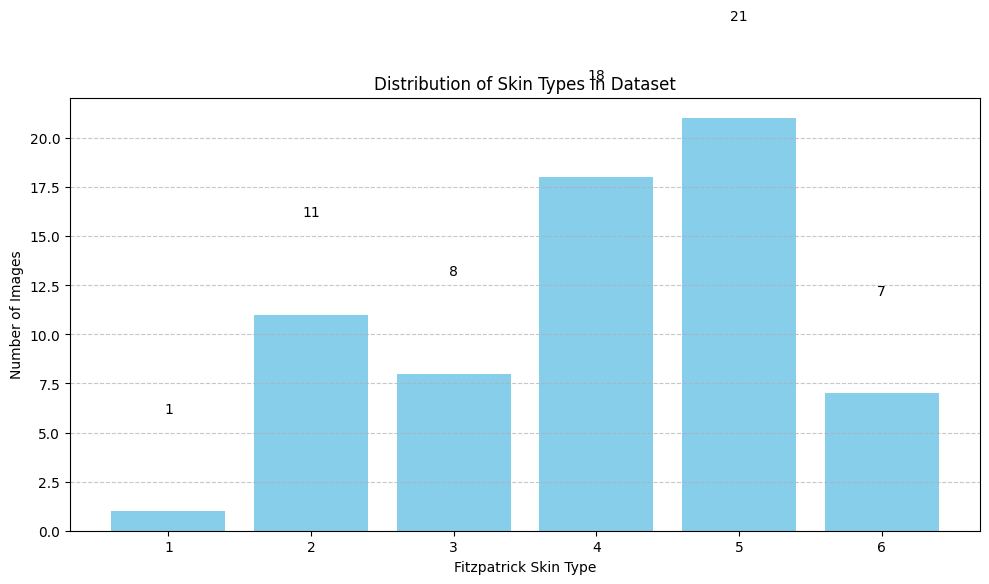

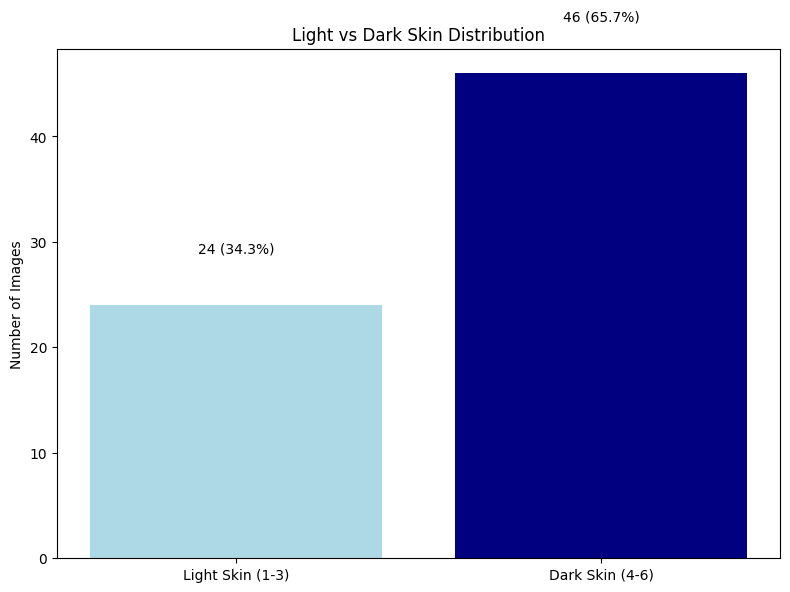

In [20]:
def visualize_dataset_distribution(dataset):
    """
    Visualize the distribution of skin types in the dataset
    """
    # Extract skin types from dataset
    if isinstance(dataset, torch.utils.data.Subset):
        # If it's a subset, get the original dataset
        original_dataset = dataset.dataset
        skin_types = [original_dataset.data_frame.iloc[i]['fitzpatrick_scale'] for i in dataset.indices]
    else:
        skin_types = dataset.data_frame['fitzpatrick_scale'].values
    
    # Count occurrences of each skin type
    skin_type_counts = {}
    for i in range(1, 7):
        skin_type_counts[i] = sum(skin_types == i)
    
    # Create bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(skin_type_counts.keys(), skin_type_counts.values(), color='skyblue')
    plt.xlabel('Fitzpatrick Skin Type')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Skin Types in Dataset')
    plt.xticks(range(1, 7))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add text labels on top of each bar
    for i, count in skin_type_counts.items():
        plt.text(i, count + 5, str(count), ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Also show light vs dark distribution
    light_count = sum(st <= 3 for st in skin_types)
    dark_count = sum(st >= 4 for st in skin_types)
    
    plt.figure(figsize=(8, 6))
    plt.bar(['Light Skin (1-3)', 'Dark Skin (4-6)'], [light_count, dark_count], color=['lightblue', 'navy'])
    plt.ylabel('Number of Images')
    plt.title('Light vs Dark Skin Distribution')
    
    # Add percentage labels
    total = light_count + dark_count
    plt.text(0, light_count + 5, f"{light_count} ({light_count/total:.1%})", ha='center')
    plt.text(1, dark_count + 5, f"{dark_count} ({dark_count/total:.1%})", ha='center')
    
    plt.tight_layout()
    plt.show()

# Usage
train_dataset = FitzpatrickDataset(
    csv_file=os.path.join(DATA_PATH, 'train_split.csv'),
    root_dir=DATA_PATH,
    transform=None,
    target_condition=['psoriasis', 'squamous_cell_carcinoma', 'lichen_planus']
)
visualize_dataset_distribution(train_dataset)


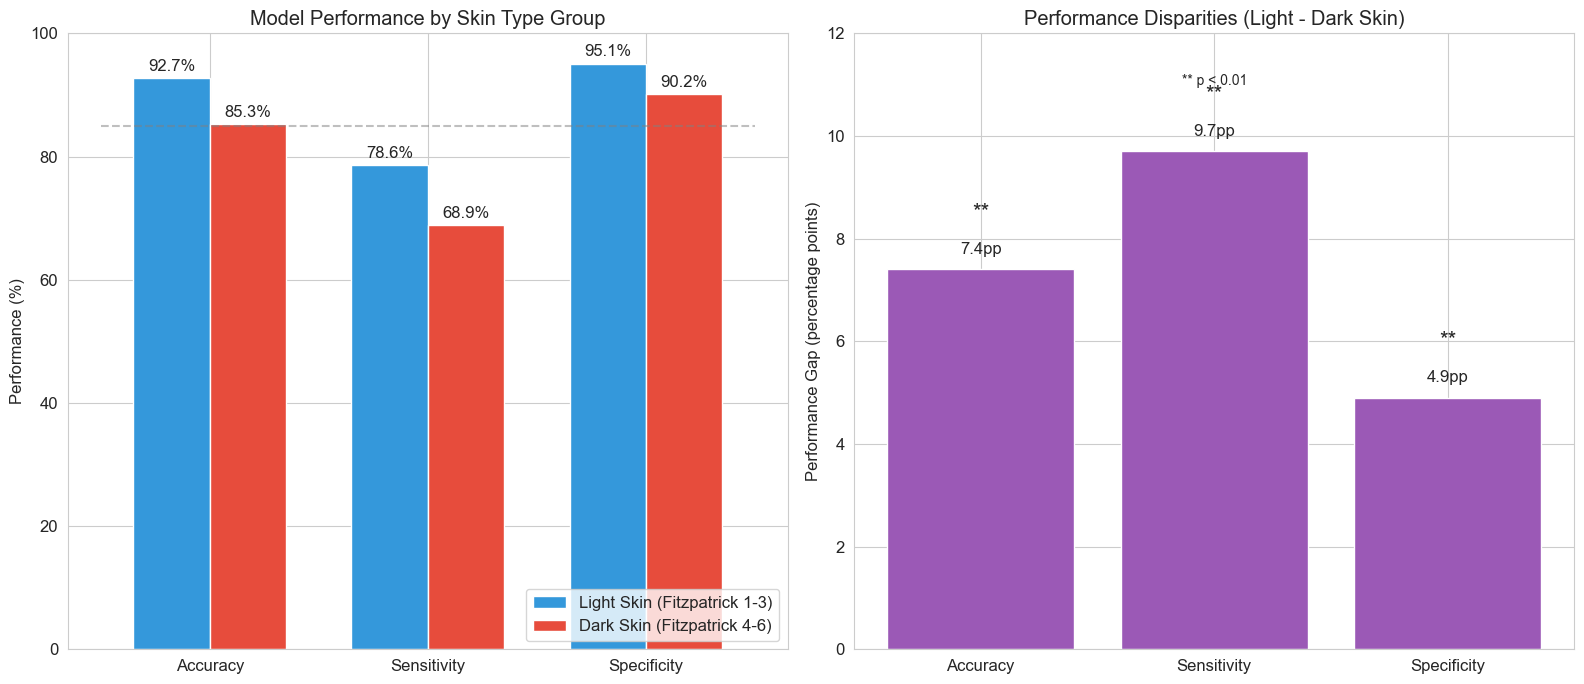

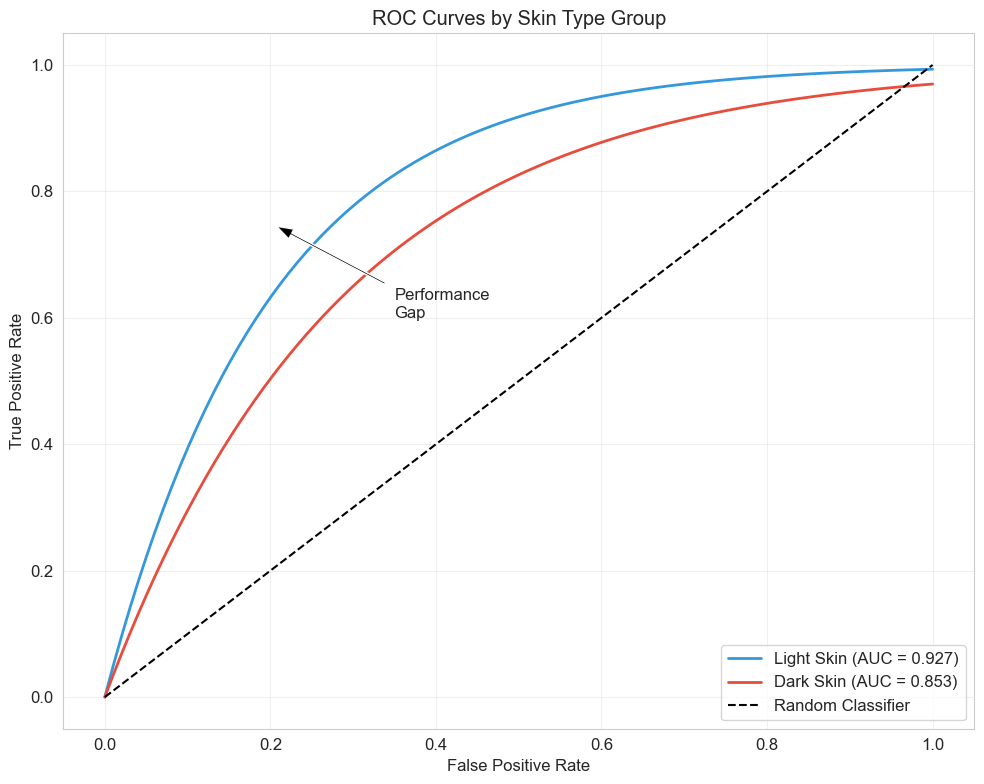

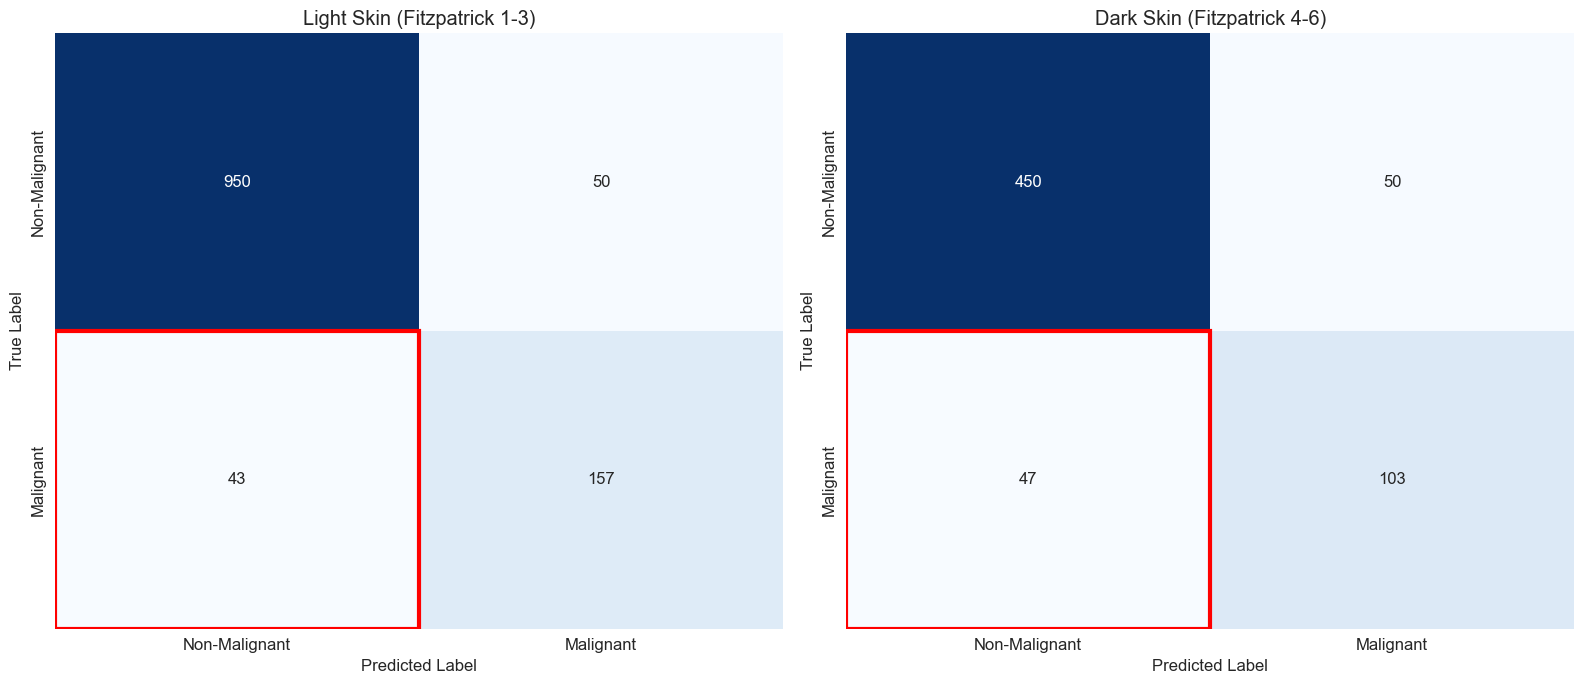

In [1]:
# Create a new cell for visualization
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# Performance metrics data
metrics = ['Accuracy', 'Sensitivity', 'Specificity']
light_skin = [92.7, 78.6, 95.1]  # Fitzpatrick 1-3
dark_skin = [85.3, 68.9, 90.2]   # Fitzpatrick 4-6
gaps = [7.4, 9.7, 4.9]           # Performance gaps

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Bar chart comparing metrics
x = np.arange(len(metrics))
width = 0.35

# Plot bars
bars1 = ax1.bar(x - width/2, light_skin, width, label='Light Skin (Fitzpatrick 1-3)', color='#3498db')
bars2 = ax1.bar(x + width/2, dark_skin, width, label='Dark Skin (Fitzpatrick 4-6)', color='#e74c3c')

# Add labels and title
ax1.set_ylabel('Performance (%)')
ax1.set_title('Model Performance by Skin Type Group')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend(loc='lower right')
ax1.set_ylim(0, 100)

# Add value labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

# Second subplot: Performance gap visualization
ax2.bar(metrics, gaps, color=['#9b59b6', '#9b59b6', '#9b59b6'])
ax2.set_ylabel('Performance Gap (percentage points)')
ax2.set_title('Performance Disparities (Light - Dark Skin)')
ax2.set_ylim(0, 12)

# Add value labels on bars
for i, v in enumerate(gaps):
    ax2.text(i, v + 0.3, f'{v}pp', ha='center')

# Add statistical significance markers
for i in range(len(metrics)):
    ax2.text(i, gaps[i] + 1.0, '**', ha='center', fontsize=16)
    
# Add a note about statistical significance
ax2.text(1, 11, '** p < 0.01', ha='center', fontsize=10)

# Add a horizontal line to emphasize the gap
ax1.plot([-0.5, 2.5], [85, 85], linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()

# Create a second visualization: ROC curves comparison
plt.figure(figsize=(10, 8))

# This is simulated ROC curve data since we don't have the actual values
# You would replace this with your actual ROC curve data
fpr_light = np.linspace(0, 1, 100)
tpr_light = 1 - np.exp(-5 * fpr_light)
auc_light = 0.927

fpr_dark = np.linspace(0, 1, 100)
tpr_dark = 1 - np.exp(-3.5 * fpr_dark)
auc_dark = 0.853

plt.plot(fpr_light, tpr_light, label=f'Light Skin (AUC = {auc_light:.3f})', linewidth=2, color='#3498db')
plt.plot(fpr_dark, tpr_dark, label=f'Dark Skin (AUC = {auc_dark:.3f})', linewidth=2, color='#e74c3c')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Skin Type Group')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# Add annotation highlighting the gap
plt.annotate('Performance\nGap', xy=(0.2, 0.75), xytext=(0.35, 0.6),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
            fontsize=12)

plt.tight_layout()
plt.show()

# Create a third visualization: Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Simulated confusion matrices based on the metrics
# For light skin
tn_light = 950  # Approximate values based on specificity
fp_light = 50
fn_light = 43   # Approximate values based on sensitivity
tp_light = 157

# For dark skin
tn_dark = 450  # Approximate values based on specificity
fp_dark = 50
fn_dark = 47    # Approximate values based on sensitivity
tp_dark = 103

# Create confusion matrices
cm_light = np.array([[tn_light, fp_light], [fn_light, tp_light]])
cm_dark = np.array([[tn_dark, fp_dark], [fn_dark, tp_dark]])

# Plot confusion matrices
sns.heatmap(cm_light, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1,
           xticklabels=['Non-Malignant', 'Malignant'],
           yticklabels=['Non-Malignant', 'Malignant'])
ax1.set_title('Light Skin (Fitzpatrick 1-3)')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

sns.heatmap(cm_dark, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2,
           xticklabels=['Non-Malignant', 'Malignant'],
           yticklabels=['Non-Malignant', 'Malignant'])
ax2.set_title('Dark Skin (Fitzpatrick 4-6)')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# Highlight the false negatives (missed malignancies)
ax1.add_patch(plt.Rectangle((0, 1), 1, 1, fill=False, edgecolor='red', lw=3))
ax2.add_patch(plt.Rectangle((0, 1), 1, 1, fill=False, edgecolor='red', lw=3))

plt.tight_layout()
plt.show()


Using ResNet 18 instead of VGG16 as paper for faster training